## Requirements

Download and install the latest versions of catalyst and other libraries required for this tutorial.

In [1]:
!python -m pip install pytorch_lightning -qqq

     |████████████████████████████████| 696kB 5.6MB/s 
     |████████████████████████████████| 102kB 6.7MB/s 
     |████████████████████████████████| 276kB 9.2MB/s 
     |████████████████████████████████| 829kB 11.8MB/s 
     |████████████████████████████████| 1.3MB 11.6MB/s 
     |████████████████████████████████| 143kB 23.7MB/s 
     |████████████████████████████████| 296kB 21.5MB/s 


In [3]:
# !python -m pip install pytorch-lightning-bolts -qqq

In [4]:
# !python -m pip install pip install wandb -qqq

In [6]:
import torch
from torch import nn as nn
from torch.nn import functional as F


class UNet(nn.Module):
    """
    Paper: `U-Net: Convolutional Networks for Biomedical Image Segmentation
    <https://arxiv.org/abs/1505.04597>`_

    Paper authors: Olaf Ronneberger, Philipp Fischer, Thomas Brox

    Implemented by:

        - `Annika Brundyn <https://github.com/annikabrundyn>`_
        - `Akshay Kulkarni <https://github.com/akshaykvnit>`_

    Args:
        num_classes: Number of output classes required
        input_channels: Number of channels in input images (default 3)
        num_layers: Number of layers in each side of U-net (default 5)
        features_start: Number of features in first layer (default 64)
        bilinear: Whether to use bilinear interpolation or transposed convolutions (default) for upsampling.
    """

    def __init__(
        self,
        num_classes: int,
        input_channels: int = 3,
        num_layers: int = 5,
        features_start: int = 64,
        bilinear: bool = False
    ):

        if num_layers < 1:
            raise ValueError(f'num_layers = {num_layers}, expected: num_layers > 0')

        super().__init__()
        self.num_layers = num_layers

        layers = [DoubleConv(input_channels, features_start)]

        feats = features_start
        for _ in range(num_layers - 1):
            layers.append(Down(feats, feats * 2))
            feats *= 2

        for _ in range(num_layers - 1):
            layers.append(Up(feats, feats // 2, bilinear))
            feats //= 2

        layers.append(nn.Conv2d(feats, num_classes, kernel_size=1))

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        xi = [self.layers[0](x)]
        # Down path
        for layer in self.layers[1:self.num_layers]:
            xi.append(layer(xi[-1]))
        # Up path
        for i, layer in enumerate(self.layers[self.num_layers:-1]):
            xi[-1] = layer(xi[-1], xi[-2 - i])
        return self.layers[-1](xi[-1])


class DoubleConv(nn.Module):
    """
    [ Conv2d => BatchNorm (optional) => ReLU ] x 2
    """

    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)


class Down(nn.Module):
    """
    Downscale with MaxPool => DoubleConvolution block
    """

    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.net = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2), DoubleConv(in_ch, out_ch))

    def forward(self, x):
        return self.net(x)


class Up(nn.Module):
    """
    Upsampling (by either bilinear interpolation or transpose convolutions)
    followed by concatenation of feature map from contracting path, followed by DoubleConv.
    """

    def __init__(self, in_ch: int, out_ch: int, bilinear: bool = False):
        super().__init__()
        self.upsample = None
        if bilinear:
            self.upsample = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
                nn.Conv2d(in_ch, in_ch // 2, kernel_size=1),
            )
        else:
            self.upsample = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)

        # Pad x1 to the size of x2
        diff_h = x2.shape[2] - x1.shape[2]
        diff_w = x2.shape[3] - x1.shape[3]

        x1 = F.pad(x1, [diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2])

        # Concatenate along the channels axis
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [42]:
import pytorch_lightning as pl

class PyLtUnet(pl.LightningModule):

    def __init__(
        self,
        num_classes: int = 19,
        num_layers: int = 5,
        lr: float = 0.01,
        features_start: int = 64,
        bilinear: bool = False
    ):
        """
        Basic model for semantic segmentation. Uses UNet architecture by default.
        The default parameters in this model are for the KITTI dataset. Note, if you'd like to use this model as is,
        you will first need to download the KITTI dataset yourself. You can download the dataset `here.
        <http://www.cvlibs.net/datasets/kitti/eval_semseg.php?benchmark=semantics2015>`_
        Implemented by:
            - `Annika Brundyn <https://github.com/annikabrundyn>`_
        Args:
            num_layers: number of layers in each side of U-net (default 5)
            features_start: number of features in first layer (default 64)
            bilinear: whether to use bilinear interpolation (True) or transposed convolutions (default) for upsampling.
            lr: learning (default 0.01)
        """
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.features_start = features_start
        self.bilinear = bilinear
        self.lr = lr

        self.net = UNet(
            num_classes=num_classes,
            num_layers=self.num_layers,
            features_start=self.features_start,
            bilinear=self.bilinear
        )

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        img, mask = batch
        img = img.float()
        mask = mask.long()
        out = self(img)
        loss_val = F.cross_entropy(out, mask, ignore_index=250)
        log_dict = {'train_loss': loss_val}
        return {'loss': loss_val, 'log': log_dict, 'progress_bar': log_dict}

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        img = img.float()
        mask = mask.long()
        out = self(img)
        loss_val = F.cross_entropy(out, mask, ignore_index=250)
        return {'val_loss': loss_val}

    def validation_epoch_end(self, outputs):
        loss_val = torch.stack([x['val_loss'] for x in outputs]).mean()
        log_dict = {'val_loss': loss_val}
        return {'log': log_dict, 'val_loss': log_dict['val_loss'], 'progress_bar': log_dict}

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
        return [opt], [sch]


In [43]:
model = UNet(num_classes = 1, input_channels=3)
x = torch.rand(5, 3, 64, 64)
out = model(x)
out.shape

torch.Size([5, 1, 64, 64])

In [56]:
import pytorch_lightning as pl

model = PyLtUnet(num_classes = 1)
trainer = pl.Trainer(gpus=1, progress_bar_refresh_rate  = 100)
trainer.fit(model, seg_data_module)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | net  | UNet | 31.0 M
------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params


RuntimeError: ignored

# Download dataset to colab

In [10]:
!ls

sample_data


In [11]:
import requests
from zipfile import ZipFile
from pathlib import Path

class google_drive_downloader():
    # credit: converted to class from https://stackoverflow.com/a/39225039

    def __init__(self, cwd_path=None, data_path=None):
        """
        data_path: root directory of where to extract data
        """

        if cwd_path is None:
            # By default, we will assume '.' data
            self.cwd_path = Path('.').absolute()
        else:
            self.cwd_path = cwd_path.absolute()

        if data_path is None:
            # By default, we will assume ./data
            self.data_path = self.cwd_path / 'data'
        else:
            self.data_path = data_path.absolute()

        if not self.data_path.exists():
            self.data_path.mkdir()

        self.zip_fname = self.cwd_path / 'tmp_download_from_gdrive.zip'

    def get_confirm_token(self, response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(self, response):
        CHUNK_SIZE = 32768

        with open(self.zip_fname, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    def download_as_zip(self, gdrive_id):
        URL = "https://docs.google.com/uc?export=download"

        session = requests.Session()

        response = session.get(URL, params = { 'id' : gdrive_id }, stream = True)
        token = self.get_confirm_token(response)

        if token:
            params = { 'id' : gdrive_id, 'confirm' : token }
            response = session.get(URL, params = params, stream = True)

        self.save_response_content(response)    


    def unzip_to_data_path(self):
        """Extract data to data path"""
        with ZipFile(self.zip_fname, 'r') as zf:
            zf.extractall(path=self.data_path)

    def remove_archive_subfolder(self, archive_subfolder):
        """
        Move: /data_path/unwanted_folder/train -> /data_path/train
        """
        # Create path with unwanted_folder
        move_up_path = self.data_path / archive_subfolder

        # Move all directories
        for folder in move_up_path.iterdir():
            if folder.is_dir():
                new_folder = folder.parent.parent / folder.name
                folder.rename(new_folder)


        # Delete the unwanted_folder directory
        move_up_path.rmdir()

    def print_data_path_contents(self):
        print(f"data_path:{self.data_path}")
        print("directory list:")
        # print data_path contents
        for folder in self.data_path.iterdir():
            print(folder)

    def import_gdrive_dataset(self, gdrive_id, archive_subfolder=None):
        """
           1. downloads the data from the specified gdrive_id as a zip 
           2. extracts the downloaded data to the specified data_path
           3. deletes the temporary zip file
        """
        self.download_as_zip(gdrive_id)
        self.unzip_to_data_path()

        # Delete the temporary file (using Path)
        self.zip_fname.unlink()

        if archive_subfolder is not None:
            self.remove_archive_subfolder(archive_subfolder)

        # Display result
        self.print_data_path_contents()



In [12]:
!ls
gdd = google_drive_downloader()
gdd.import_gdrive_dataset(gdrive_id='1iYaNijLmzsrMlAdMoUEhhJuo-5bkeAuj', archive_subfolder='segmentation_data')

sample_data
data_path:/content/data
directory list:
/content/data/train
/content/data/test
/content/data/train_masks


In [13]:
from pathlib import Path
import random

class pathlib_utils():
    """
    paths: place to keep track of all paths used within this project
            : CWD is the root path for the current working directory
            : DATA is the root path for all data (may or may not be inside CWD)

    dir_type: ['images','dirs'] :: Indicates whether this folder contains subdirectories, or images

    """

    def __init__(self, DATA='.', CWD='.'):

        # Pathlib Path(), for each key
        self.paths = {'ROOT': Path('/'),
                      'DATA': Path(DATA), 
                      'CWD': Path(DATA) }

        # Full Path(), for each key
        self.path_lists = {'DATA': self.get_path_lists('DATA'), 
                           'CWD': self.get_path_lists('CWD') }

        # Same as path_lists but only file/dir names, for each key
        init_data_names, _ = self.get_name_lists('DATA')
        init_cwd_names, _ = self.get_name_lists('CWD')
        self.name_lists = {'DATA': init_data_names, 
                           'CWD': init_cwd_names }

        # Length of each self.path_lists, for each key
        self.len = {'DATA': len(self.path_lists['DATA']), 
                   'CWD': len(self.path_lists['DATA']) }

        # Flag to indicate whether each list in self.path_lists is image or subdirectories, for each key
        self.dir_type = {'ROOT': 'dirs',
                         'DATA': 'dirs',
                         'CWD': 'dirs' }

 
    def add(self, new_paths, ROOT='ROOT'):

        assert ROOT in self.paths.keys()
        for key, value in new_paths.items():
            # Append value to path
            self.paths[key] = self.paths[ROOT] / value
            self.path_lists[key] = self.get_path_lists(key)
            self.name_lists[key], self.dir_type[key] = self.get_name_lists(key)
            self.len[key] = len(self.path_lists[key])

    def get_path_lists(self, PATH_KEY):

        image_files = sorted([x for x in self.paths[PATH_KEY].glob("*.jpg")]+[x for x in self.paths[PATH_KEY].glob("*.gif")])
        # If list is empty, then provide a list sub directories
        if not image_files:
            dirs = [x for x in self.paths[PATH_KEY].iterdir() if x.is_dir()]
            return dirs, 'dirs'
        else:
            return image_files

    def get_name_lists(self, PATH_KEY):

        image_files = sorted([x.name for x in self.paths[PATH_KEY].glob("*.jpg")]+[x.name for x in self.paths[PATH_KEY].glob("*.gif")])
        # If list is empty, then provide a list sub directories
        if not image_files:
            dirs = [x.name for x in self.paths[PATH_KEY].iterdir() if x.is_dir()]
            return dirs, 'dirs'
        else:
            return image_files, 'images'



    def get_image(self, PATH_KEY, image_idx):
        if self.dir_type[PATH_KEY] != 'images':
            print("The directory {PATH_KEY1} has no images")
            return None

        return self.path_lists[PATH_KEY][image_idx]


    def get_image_pairs(self, PATH_KEY1, PATH_KEY2, image_idx):
        # Sometimes we would like to get a pair of corresponding images/files
        # E.g., an image and its corresponding mask
        # This function provides an assert option to ensure the filenames match
        # e.g., f1.abc f2.xyz = f1something.xyz

        if self.dir_type[PATH_KEY1] != 'images':
            print("The directory {PATH_KEY1} has no images")
            return None

        if self.dir_type[PATH_KEY2] != 'images':
            print("The directory {PATH_KEY2} has no images")
            return None

        f1 = self.path_lists[PATH_KEY1][image_idx].stem 
        f2 = self.path_lists[PATH_KEY2][image_idx].stem
        assert f2.startswith(f1)
        return self.path_lists[PATH_KEY1][image_idx],  self.path_lists[PATH_KEY2][image_idx]    


    def get_random_image_pairs(self, PATH_KEY1, PATH_KEY2, N=1):
        # Return a list with each entry in the list containing the resulting pair
        if self.dir_type[PATH_KEY1] != 'images':
            print("This directory has no images")
            return None

        length = self.len[PATH_KEY1]
        list_of_pairs = []
        for _ in range(N):
            image_idx = random.randint(0, length - 1)
            list_of_pairs.append(self.get_image_pairs(PATH_KEY1, PATH_KEY2, image_idx))

        return list_of_pairs
 

## Create pathlib util object

* Suppose we wish to store our images in `\content\data` and our current working directory will be `\content\mount\drive\projects\my_project`

We can create the pathlib_utils object as follows
```
pu = pathlib_utils(DATA = '/content/data')
```

Later we could update this as follows
```
pu.add({'CWD':'\content\mount\drive\projects\my_project'})
```



* Suppose our dataset contains three folders, one for train images, one for test images and one for train_masks.
* We create a dictionary with some consistent key and the folder names of each of those

```
sub_dirs_with_keys = {'TRAIN': "train", 
                      'TRAIN_MASK' : "train_masks", 
                       'TEST' : "test"}
pu.add(sub_dirs_with_keys)
```

## We now have a class that organises in the following way

* We store the path for the root training and current workign directory
* We store the path for the train, train_mask and test data (which contain images (jpg or gifs)
* We can access the Pathlib.Path by `pu.paths['TRAIN']`
* We can access a sorted list of the files in a directory containing files by `pu.path_lists['TRAIN']`
* Or, if that directory does not contain any files, assume it contains directories. We print (recursively) all subdirectories by `pu.path_lists['DATA']`
* While `pu.path_lists` prints the full path list, we can do the same thing, but only the file name with the commands `pu.ls['TRAIN']` or `pu.ls['DATA']`
* We can get the number of train/test/mask images by `pu.len['TRAIN']` (or simply `len(pu.ls['TRAIN'])`

In [14]:
# Create pathlib_utils and add folder structure
pu = pathlib_utils(DATA = '/content/data')

# Later add the CWD
pu.add({'CWD':'content'}, ROOT='ROOT')

# Add the folder structure we desire
sub_dirs_with_keys = {'TRAIN': "train", 
                      'TRAIN_MASKS' : "train_masks", 
                       'TEST' : "test"}
pu.add(sub_dirs_with_keys, ROOT='DATA')

In [15]:
# Some possible commands
print(pu.paths['TRAIN'])
print(pu.paths['DATA'])
print(pu.path_lists['TRAIN_MASKS'])
print(pu.name_lists['TRAIN_MASKS'])
print(pu.len['TRAIN'])

/content/data/train
/content/data
[PosixPath('/content/data/train_masks/00087a6bd4dc_01_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_02_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_03_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_04_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_05_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_06_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_07_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_08_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_09_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_10_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_11_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_12_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_13_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_14_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_15_ma

In [16]:
print(pu.get_image('TEST',21))

/content/data/test/000f19f6e7d4_06.jpg


In [17]:
print(pu.get_image_pairs('TRAIN','TRAIN_MASKS',21))

(PosixPath('/content/data/train/02159e548029_06.jpg'), PosixPath('/content/data/train_masks/02159e548029_06_mask.gif'))


In [18]:
print(pu.get_random_image_pairs('TRAIN','TRAIN_MASKS',10))


[(PosixPath('/content/data/train/0795e132d090_06.jpg'), PosixPath('/content/data/train_masks/0795e132d090_06_mask.gif')), (PosixPath('/content/data/train/86c10c8c6206_16.jpg'), PosixPath('/content/data/train_masks/86c10c8c6206_16_mask.gif')), (PosixPath('/content/data/train/85bc655a7523_03.jpg'), PosixPath('/content/data/train_masks/85bc655a7523_03_mask.gif')), (PosixPath('/content/data/train/db09fec614d2_03.jpg'), PosixPath('/content/data/train_masks/db09fec614d2_03_mask.gif')), (PosixPath('/content/data/train/0d53224da2b7_12.jpg'), PosixPath('/content/data/train_masks/0d53224da2b7_12_mask.gif')), (PosixPath('/content/data/train/4dc8a7fe7c02_03.jpg'), PosixPath('/content/data/train_masks/4dc8a7fe7c02_03_mask.gif')), (PosixPath('/content/data/train/99639c826ea5_15.jpg'), PosixPath('/content/data/train_masks/99639c826ea5_15_mask.gif')), (PosixPath('/content/data/train/e05b96cc2b0d_06.jpg'), PosixPath('/content/data/train_masks/e05b96cc2b0d_06_mask.gif')), (PosixPath('/content/data/train

## Utility to view data


In [31]:
import random
import matplotlib.pyplot as plt
from skimage import io
#.io import imread as gif_imread
import numpy as np
from PIL import Image
from threading import Thread

class image_utils():

    def __init__(self, image_type=np.ndarray):
        """Associate this instance with either PIL.Image or skimage.io (numpy.ndarray)"""
        self.image_type = image_type

    def show_image_mask_pair(self, image1, image2, name=''):

        # PIL image case
        if self.image_type == Image.Image:
            
            if not isinstance(image1, self.image_type):
                # image not yet loaded
                image1 = Image.open(image1)

            if not isinstance(image2, self.image_type):
                # image not yet loaded
                image2 = Image.open(image2)

            self.show_pil_image_mask_pair(image1, image2, name)

        elif self.image_type == np.ndarray:
            if not isinstance(image1, self.image_type):
                # image not yet loaded
                image1 = io.imread(image1)

            if not isinstance(image2, self.image_type):
                # image not yet loaded
                image2 = io.imread(image2)
            self.show_skimage_image_mask_pair(image1, image2, name)

    def show_skimage_image_mask_pair(self, image1, image2, name=''):
        # Accepts image directly or path to image

        plt.figure(figsize=(10, 14))
        plt.subplot(1, 2, 1)
        plt.imshow(image1)
        plt.title(f"Image: {name}")

        plt.subplot(1, 2, 2)
        plt.imshow(image2)
        plt.title(f"Mask: {name}")

    def show_pil_image_mask_pair(self, image1, image2, name=''):
        # Accepts image directly or path to image

        result_image = Image.new('RGB', (image1.width + image2.width, min(image1.height, image2.height)))
        result_image.paste(image1, (0, 0))
        result_image.paste(image2, (image1.width, 0))
        plt.imshow(result_image)


    def torch_dataset_iterator(self, dataset):
        #fig = plt.figure()
        temp_image_type = self.image_type
        self.image_type = type(dataset[0][0])

        for i in range(len(dataset)):
            image, mask = dataset[i]
            #print(type(image), type(mask))
            self.show_skimage_image_mask_pair(image, mask)

            if i == 3:
                plt.show()
                break

        self.image_type = temp_image_type

iu = image_utils()

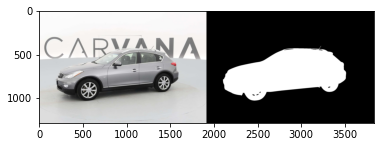

In [32]:
# Work with PIL
iu_pil = image_utils(image_type=Image.Image)
random_image_mask_pairs =pu.get_random_image_pairs('TRAIN','TRAIN_MASKS',1)
for image, mask in random_image_mask_pairs:
    iu_pil.show_image_mask_pair(image, mask)

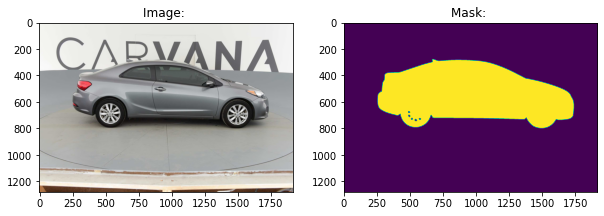

In [29]:
# Work with skimage
random_image_mask_pairs =pu.get_random_image_pairs('TRAIN','TRAIN_MASKS',1)
for image, mask in random_image_mask_pairs:
    iu.show_image_mask_pair(image, mask)

# Create Torch Dataset

Next we will create a torch.utils.data.Dataset for our segmentation problem.

Here, we should define
* `__init__()`
* `__len__()`
* `__getitem__()`

In [45]:
from torch.utils.data import Dataset, DataLoader

class SegmentationDataset(Dataset):
    # Sample of our dataset will be a dict {'image': image, 'mask': mask}

    def __init__(self, images_path_list, masks_path_list, transform=None, scale=0.1):
        self.images_path_list = images_path_list
        self.masks_path_list = masks_path_list
        self.transform = transform
        self.scale = scale

    def __len__(self):
        return len(self.images_path_list)

    def __getitem__(self, idx):

        # if torch.is_tensor(idx):
        #     idx = idx.tolist()

        image_path = self.images_path_list[idx]
        
        image = Image.open(image_path)
        image = self.preprocess(image)
        #image = np.array(image)

        if self.masks_path_list is not None:
            mask_path = self.masks_path_list[idx]
            mask = Image.open(mask_path)
            mask = self.preprocess(mask)
            #mask = np.array(mask)    
        else:
            mask = None
            
        if self.transform:
            image = self.transform(image)

        #sample = {'image':  image, 'mask':  mask}
        sample = image, mask

        return sample

    def preprocess(self, image):
        """
        Method to preprocess this specific dataset includig transposing
        height-width-channel to channel-height-width (as expected by the Unet)
        """
        #print(type(image))
        w, h = image.size
        new_w, new_h = int(self.scale * w), int(self.scale * h)

        assert new_w > 0 and new_h > 0

        image = image.resize((new_w, new_h))
        image = np.array(image)

        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=2)

        # HWC to CHW
        img_trans = image.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans

In [46]:
seg_dataset = SegmentationDataset(pu.path_lists['TRAIN'],\
                                  pu.path_lists['TRAIN_MASKS'],\
                                  None)


TypeError: ignored

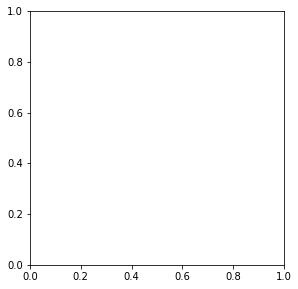

In [47]:
iu.torch_dataset_iterator(seg_dataset)

In [48]:
batch_size=4
num_workers=4

# Catalyst uses normal torch.data.DataLoader
seg_loader = DataLoader(
    seg_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)




In [49]:
from torch.utils.data import random_split, DataLoader
val_size=0.1


In [50]:
val_samples = int(len(seg_dataset)*val_size)
train_samples = len(seg_dataset) - val_samples
t, v = random_split(seg_dataset, [train_samples, val_samples])
print(len(t), train_samples, len(v), val_samples, len(seg_dataset))

4580 4580 508 508 5088


# Dataloaders

In [51]:
import pytorch_lightning as pl
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

class SegmentationDataModule(pl.LightningDataModule):

    def __init__(self, train_path, masks_path, val_size=0.1, batch_size=32, num_workers=4, drop_last=True):
        super().__init__()
        self.train_path = train_path
        self.masks_path = masks_path
        # self.transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize((0.1307,), (0.3081,))
        # ])
        self.transform = None

        # Size of validation set (as a percentage)
        self.val_size = val_size

        # Useful variables to have contol over at init
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.drop_last = drop_last

    def prepare_data(self):
        # download (could possibly call googledrive downloader utility here??)
        #MNIST(self.data_dir, train=True, download=True)
        #MNIST(self.data_dir, train=False, download=True)
        pass

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:

            full_train_dataset = SegmentationDataset(self.train_path, self.masks_path, transform=self.transform)

            num_val_samples = int(len(full_train_dataset)*self.val_size)
            num_train_samples = len(full_train_dataset) - val_samples

            self.train_dataset, self.val_dataset = random_split(full_train_dataset, [num_train_samples, num_val_samples])

            self.dims = tuple(self.train_dataset[0][0].shape)

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:

            self.test_dataset = SegmentationDataset(self.test_path, None, transform=self.transform)

            self.dims = getattr(self, 'dims', self.test_dataset[0][0].shape)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                          batch_size=self.batch_size,
                          shuffle=True,
                          num_workers=self.num_workers,
                          drop_last=self.drop_last
                          )

    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers,
                          drop_last=self.drop_last
                          )

    def test_dataloader(self):
        return DataLoader(self.test_dataset, 
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers,
                          drop_last=self.drop_last
                          )


In [52]:
seg_data_module = SegmentationDataModule(pu.path_lists['TRAIN'],\
                                  pu.path_lists['TRAIN_MASKS'])

seg_data_module.prepare_data()
seg_data_module.setup('fit')


In [53]:
i =0 
for image, mask in seg_data_module.train_dataloader():
    print(type(image), type(mask))
    print(i)
    i=i+1
    if i ==5:
        break

<class 'torch.Tensor'> <class 'torch.Tensor'>
0
<class 'torch.Tensor'> <class 'torch.Tensor'>
1
<class 'torch.Tensor'> <class 'torch.Tensor'>
2
<class 'torch.Tensor'> <class 'torch.Tensor'>
3
<class 'torch.Tensor'> <class 'torch.Tensor'>
4


In [54]:
print(model)

PyLtUnet(
  (net): UNet(
    (layers): ModuleList(
      (0): DoubleConv(
        (net): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): Down(
        (net): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): DoubleConv(
            (net): Sequential(
              (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
              (3): Conv2d(128, 128, kernel_siz

In [55]:
import pytorch_lightning as pl

trainer = pl.Trainer()
trainer.fit(model, seg_data_module)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name | Type | Params
------------------------------
0 | net  | UNet | 31.0 M
------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params


RuntimeError: ignored